Welcome to my solution to DigitRecognition assignment from kaggle(https://www.kaggle.com/competitions/digit-recognizer/overview). In this particular Jupyter notebook I'll mostly put all of my efforts on data analysis, since trees and ensembles do not suit image recognition problems, but I want to get maximum accuracy out of RandomForestClassifier algorithm. So lets get started by importing all needed packages and loading data.

In [223]:
import sys
import sklearn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pandas as pd

PROJECT_ROOT_DIR = os.path.dirname(os.getcwd())

def load_data(project_root_dir=PROJECT_ROOT_DIR):
    csv_path_test = os.path.join(PROJECT_ROOT_DIR, "data/test.csv")
    csv_path_train = os.path.join(PROJECT_ROOT_DIR, "data/train.csv")
    return pd.read_csv(csv_path_test), pd.read_csv(csv_path_train)

test_set, train_set = load_data()

train_set.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [224]:
test_set.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

def fit_estimate_trees(model, X_train, y_train):
    model.fit(X_train, y_train)
    accuracy = accuracy_score(y_train, model.predict(X_train))
    cross_score = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    print(f"Training set accuracy: {accuracy}\n"
          f"Cross-validation accuracy: {cross_score}\n"
          f"Average difference between training and cross-validation accuracies: "
          f"{accuracy-(np.sum(cross_score)/3)}")
    return model

Firstly lets train our model without any data change to have a kind of reference point. I'm using scoring="accuracy", since I believe that this error measurement suit this task. Of course, I can try calculating F1 score or ROC, but it will take additional time and "accuracy" is enough for now.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X, y = train_set.drop("label", axis=1), train_set["label"]
X_train, y_train = X[:60000], y[:60000]

rf = RandomForestClassifier(random_state=42)
rf = fit_estimate_trees(rf, X_train, y_train)

We can see that Training set error is 0, since RandomForest is good at fitting Training sets, but one drawback of this ability is overfitting. Average difference between training and cross-validation errors is around 3.8%, which, in my opinion, is a small sign of overfitting. What we can do now is to apply data scaling, ensembles and trees are not sensitive to different scales of data, since they do not use Gradient Descent algorithm, but still it can be worth trying. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
X_scaled_minmax = scaler.fit_transform(X_train)

scaler = StandardScaler()
X_scaled_standard = scaler.fit_transform(X_train)

print("StandardScaler:\n")
rf = fit_estimate_trees(rf, X_scaled_standard, y_train)

print("MinMaxScaler:\n")
rf = fit_estimate_trees(rf, X_scaled_minmax, y_train)

In some folds accuracy improved a bit, but it is not really noticeable, so as I've said Scaling is not made for ensembles and trees.

In [ ]:
plt.subplot(1, 3, 1)
plt.imshow(X_train.iloc[0].to_numpy().reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(X_scaled_minmax[0].reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off')
plt.title('MimMaxScaler Image')

plt.subplot(1, 3, 3)
plt.imshow(X_scaled_standard[0].reshape(28, 28), cmap=plt.cm.gray)
plt.axis('off')
plt.title('StandardScaler Image')

plt.tight_layout()

plt.show()

The main idea about StandartScaler for data preprocessing is to make features to look more standard normally distributed, since algorithm like PCA are sensitive to this changes. While MinMaxScaler just scales data to the provided sizes, e.g. default=(0,1).

The next step, that should increase accuracy of the system is increasing dataset by adding new instances. But how can we get more data? First thing that comes to my mind is to use data augmentation, simply shift image by one pixel to the left, right, up and down. We could also try to rotate images, but shifting, I believe, is enough. 
What I want to notice is that we can do this, since pixels on the edges carry 0 importance for the RandomForestClassifier, we can check it in the following way.

In [ ]:
importances = rf.feature_importances_
importances = importances.reshape((28,28))
plt.matshow(importances, cmap=plt.cm.hot)
plt.title("Pixel importances image")
plt.colorbar()
plt.show()

In [ ]:
def augment_images(X, width=28, height=28):
    
    num_images = len(X)

    matrix_up = np.empty((num_images, width, height))
    matrix_down = np.empty((num_images, width, height))
    matrix_left = np.empty((num_images, width, height))
    matrix_right = np.empty((num_images, width, height))

    for i in range(num_images):
        matrix_up[i] = np.zeros_like(X[i].reshape(width, height))
        matrix_up[i][:-1, :] = X[i].reshape(width, height)[1:, :]
        matrix_up[i][-1, :] = 0

        matrix_down[i] = np.zeros_like(X[i].reshape(width, height))
        matrix_down[i][1:, :] = X[i].reshape(width, height)[:-1, :]
        matrix_down[i][0, :] = 0

        matrix_left[i] = np.zeros_like(X[i].reshape(width, height))
        matrix_left[i][:, :-1] = X[i].reshape(width, height)[:, 1:]
        matrix_left[i][:, -1] = 0

        matrix_right[i] = np.zeros_like(X[i].reshape(width, height))
        matrix_right[i][:, 1:] = X[i].reshape(width, height)[:, :-1]
        matrix_right[i][:, 0] = 0

    X_augmented = np.concatenate((X, 
                                  matrix_up.reshape(num_images, -1), 
                                  matrix_down.reshape(num_images, -1), 
                                  matrix_left.reshape(num_images, -1), 
                                  matrix_right.reshape(num_images, -1)), axis=0)

    return X_augmented

In [ ]:
X_train_appended = augment_images(X_scaled_minmax)
y_train_appended = np.tile(y_train, 5)
print(X_train_appended.shape, y_train_appended.shape)

Let's check how this affected accuracy score

In [ ]:
rf = fit_estimate_trees(rf, X_train_appended, y_train_appended)

It indeed increased accuracy of the model by approximately 0.6%, which is not bad. I think, that we cannot get more accuracy by manipulating dataset, so we can try analysing, where algorithm makes mistakes by plotting confusion matrix and visualizing data.
Let's now plot confusion matrices:

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_predict = cross_val_predict(rf, X_train_appended, y_train_appended, cv=3)

confusion_m = confusion_matrix(y_train_appended, y_train_predict)
plt.matshow(confusion_m, cmap=plt.cm.gray)
plt.show()

In [ ]:
rows_sums = confusion_m.sum(axis=1, keepdims=True)
norm_confusion_m = confusion_m / rows_sums
np.fill_diagonal(norm_confusion_m, 0)
plt.matshow(norm_confusion_m, cmap=plt.cm.gray)
plt.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X_train_appended)

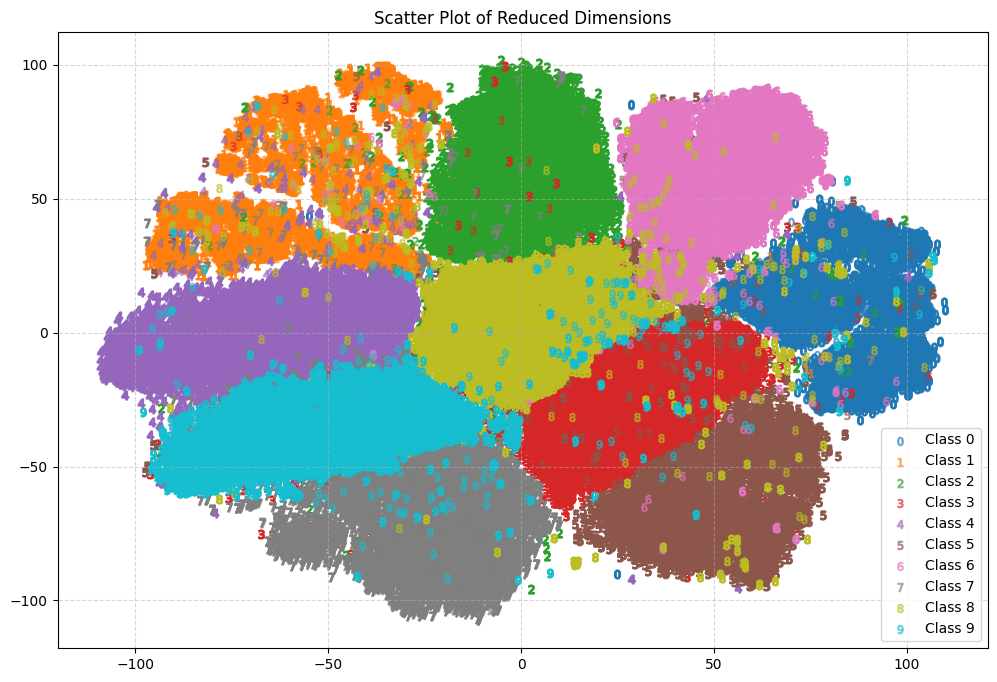

In [235]:
unique_labels = np.unique(y_train_appended)

plt.figure(figsize=(12, 8))

for label in unique_labels:
    indices = (y_train_appended == label)
    plt.scatter(X_reduced[indices, 0], X_reduced[indices, 1], label=f'Class {label}', marker=f'${label}$', alpha=0.5)

plt.title('Scatter Plot of Reduced Dimensions')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

According to the plots above, I may conclude that 9th column in norm confusion matrix says that - 9 is being confused with a lot of different digits, mainly with 4 and 8. There are other columns and vectors differ in color, but still the 9th column is the most interesting for me. 
I want to try to solve it using hog(histogram of oriented gradients) function from skimage library. It extracts the most important features from the image by computing gradients, going initially from left to right and then from up to down.

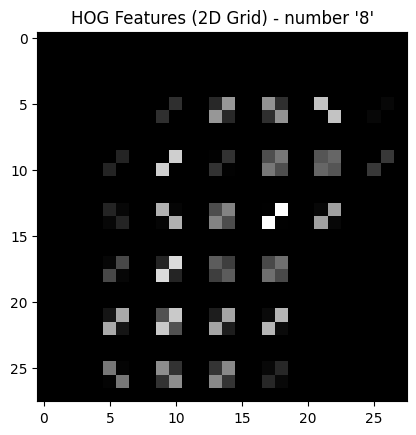

In [200]:
from skimage.feature import hog
from skimage.exposure import rescale_intensity

features, hog_image = hog(X_train_appended[10].reshape(28,28), orientations=8,  pixels_per_cell=(4, 4),
                          cells_per_block=(1, 1), visualize=True, transform_sqrt=True)


# Plot the original and HOG images
plt.imshow(hog_image, cmap=plt.cm.gray)
plt.title('HOG Features (2D Grid) - number \'8\'')

plt.show()


Here is how it looks like (note, that to get "hog_image" return value from hog function "visualize=True" must be set)

In [212]:
def hog_features(model, shape0):
    X_train_hog = np.zeros((shape0, 392))

    for i in range(model.shape[0]):
        features = hog(model[i].reshape(28, 28), orientations=8, pixels_per_cell=(4, 4),
                       cells_per_block=(1, 1), transform_sqrt=True)
    
        X_train_hog[i] = features
    return X_train_hog

In [230]:
X_train_hog = hog_features(X_train_appended, X_train_appended.shape[0])

rf_hog = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_hog = fit_estimate_trees(rf_hog, X_train_hog, y_train_appended)

Training set accuracy: 1.0
Cross-validation accuracy: [0.98037143 0.9734     0.97745714]
Average difference between training and cross-validation accuracies: 0.022923809523809457


This training set seem to be a bit better on the training set according to the cross validation accuracy score. Let's visualize it:

In [ ]:
X_reduced = tsne.fit_transform(X_train_hog)

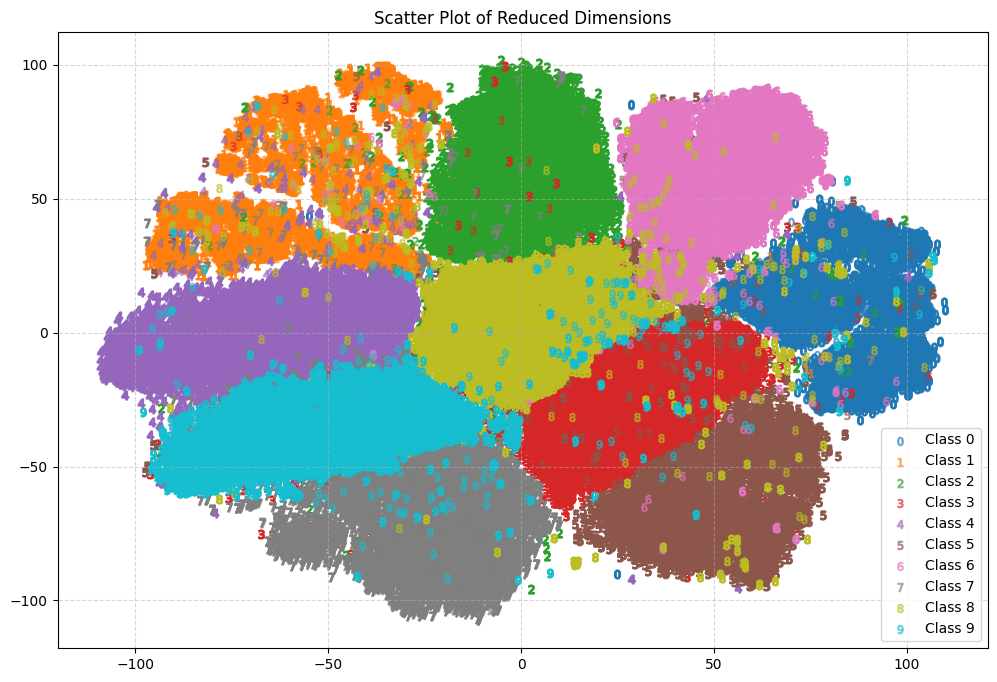

In [232]:
unique_labels = np.unique(y_train_appended)

plt.figure(figsize=(12, 8))

for label in unique_labels:
    indices = (y_train_appended == label)
    plt.scatter(X_reduced[indices, 0], X_reduced[indices, 1], label=f'Class {label}', marker=f'${label}$', alpha=0.5)

plt.title('Scatter Plot of Reduced Dimensions')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

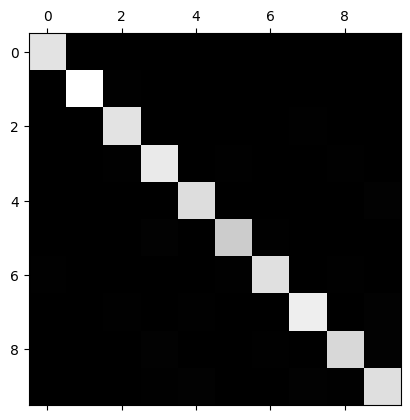

In [196]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_predict = cross_val_predict(rf_hog, X_train_hog, y_train_appended, cv=3)

confusion_m = confusion_matrix(y_train_appended, y_train_predict)
plt.matshow(confusion_m, cmap=plt.cm.gray)
plt.show()

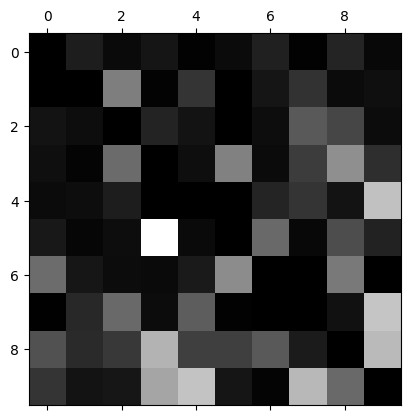

In [193]:
rows_sums = confusion_m.sum(axis=1, keepdims=True)
norm_confusion_m = confusion_m / rows_sums
np.fill_diagonal(norm_confusion_m, 0)
plt.matshow(norm_confusion_m, cmap=plt.cm.gray)
plt.show()

Plotting confusion matrices we can clearly see that the main problem became that 3 gets classified as 5 for a lot of cases. We can check which of the digits are misclassified:

ValueError: num must be an integer with 1 <= num <= 16, not 17

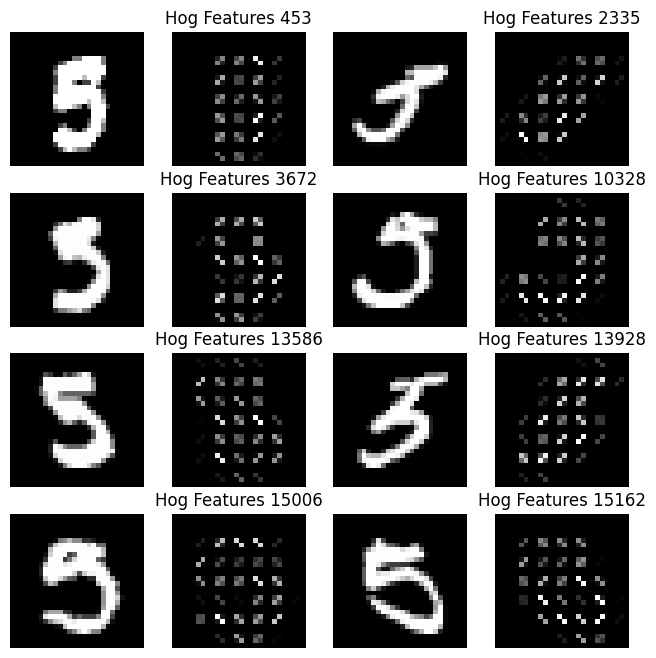

In [233]:
from skimage.feature import hog
import matplotlib.pyplot as plt
import numpy as np

# Find indices where y_predicted is 3 and y_real is 5
indices = np.where((y_train_predict == 3) & (y_train_appended == 5))[0]

# Set the figure size to fit a 5x5 grid
plt.figure(figsize=(8, 8))

# Plot images and HOG features in a 5x5 grid
num_images = min(len(indices), 25)  # Display up to 25 images
for i in range(num_images):
    index = indices[i]
    image = X_train_appended[index].reshape(28, 28)
    features, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4),
                               cells_per_block=(1, 1), transform_sqrt=True, visualize=True)

    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')

    plt.subplot(4, 4, 2 * i + 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title(f'Hog Features {index}')
    plt.axis('off')

plt.tight_layout()
plt.show()

It is sometimes hard to classify some of the digits even for a human being. To measure real performance of the system we actually need some value to compare with, like human evaluation of this set, but I do not have time to get through all of this digits and classify them manually. So I'd like to end it here, since I wasn't ably to increase performance of this classifier, but now I try to choose better algorithm for this kind of tasks - Clustering.

In [226]:
scaler = MinMaxScaler()
test_set = scaler.fit_transform(test_set)
test_set = hog_features(test_set, test_set.shape[0])

y_pred = rf_hog.predict(test_set)

In [227]:
import pandas as pd

# Sample data (replace these with your actual data)
image_ids = range(1, 28001)  # Assuming Image IDs start from 1 and go up to 28000
# Create a DataFrame
df = pd.DataFrame({'Imageid': image_ids, 'Label': y_pred})

# Specify the file path where you want to save the CSV file
file_path = 'predictions_reg_hog.csv'

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False)